<a href="https://colab.research.google.com/github/ZonaQuant/Notebooks/blob/main/Copia_de_COMPARATIVA_DE_MODELOS_SUPERVISADOS_DE_MACHINE_LEARNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. PRESENTACIÓN

En este notebook se va a comparar el rendimiento medido en términos de tiempo de entrenamiento y precisión obtenida fuera de muestra de diferentes modelos supervisados.


In [ ]:
!pip install yfinance 
import yfinance as yf
!pip install talib-binary
import talib as tl
import numpy as np
import pandas as pd
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import timeit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#1. GENERACIÓN DEL DATASET

Para mantener sencillo el ejemplo, utilizamos sólo 6 indicadores con múltiples parámetros y generamos etiquetas simples en función del retorno a 1 día.

In [ ]:
#FUNCIÓN PARA GENERAR DATASET
def dataset(ticker, days):
  #DEFINIMOS EL PERIODO A DESCARGAR
  today = datetime.today()
  initial = today - dt.timedelta(days=days)
  today = today.strftime('%Y-%m-%d')
  initial = initial.strftime('%Y-%m-%d')
  #DESCARGAMOS LOS DATOS CON YFINANCE
  data = yf.download(ticker, start=initial, end=today, progress=False)
  #DEFINIMOS LAS VARIABLES CON LAS QUE SE CALCULAN LOS INDICADORES
  high = np.array(data["High"])
  low = np.array(data["Low"])
  close = np.array(data["Close"])
  #CREAMOS LAS LISTAS EN LAS QUE GUARDAMOS EL VALOR DEL INDICADOR Y EL NOMBRE DEL INDICADOR
  ta = []
  columns = []   
  #CREAMOS UNA LISTA DE VALORES QUE SERÁN UTILIZADOS COMO PARÁMETROS PARA LOS INDICADORES
  periods = list(range(5,50))
  #CCI - Commodity Channel Index
  for n in periods:
    name = "CCI" + str(n)
    ta.append(pd.Series(tl.CCI(high, low, close, timeperiod=n)))
    columns.append(name)
  #RSI - Relative Strength Index
  for n in periods:
    name = "RSI" + str(n)
    ta.append(pd.Series(tl.RSI(close, timeperiod=n)))
    columns.append(name) 
  #STOCH - Stochastic
  for n in periods:
    name_k = "STOCHK" + str(n)
    name_d = "STOCHD" + str(n)
    fastk, fastd = tl.STOCHF(high, low, close, fastk_period=n, fastd_period=3, fastd_matype=0)
    ta.append(pd.Series(fastk))        
    columns.append(name_k)   
    ta.append(pd.Series(fastd))        
    columns.append(name_d)     
  #WILLR - Williams' %R
  for n in periods:
    name = "WILLR" + str(n)
    ta.append(pd.Series(tl.WILLR(high, low, close, timeperiod=n)))
    columns.append(name)
  #ADX
  for n in [5,10,15,20,25]:
    name = "ADX" + str(n)
    ta.append(pd.Series(tl.ADX(high, low, close, timeperiod=n)))
    columns.append(name)    
  #MACD - Moving Average Convergence/Divergence
  for n in periods:
    name = "MACD" + str(n)
    macd, macdsignal, macdhist = tl.MACD(close, fastperiod=int(n/2), slowperiod=n, signalperiod=9)
    ta.append(pd.Series(macd))
    columns.append(name)      
  #CREAMOS DATAFRAME CON LOS INDICADORES GENERADOS
  df = pd.concat(ta, axis=1)
  df.columns = columns
  df.index = data.index
  df["Close"] = data["Close"]
  #CALCULAMOS RETORNO A UN DÍA VISTA
  df["Return"] = df["Close"].pct_change().shift(-1)
  #GENERAMOS VARIABLE DEPENDIENTE
  df["Label"] = np.where(df["Return"]>0,"UP","DOWN")
  #ELIMINAMOS VALORES NULOS
  df = df.dropna()
  return df

#2. GENERACIÓN DEL OOS Y DE IS DE DIFERENTES LONGITUDES

Realizamos la siguiente aproximación: 1 año son unas 250 muestras.

Reservamos el último año como oos y generamos in samples de diferentes longitudes.

Utilizamos EURUSD para obtener unas etiquetas más balanceadas de las que obtendríamos con activos con tanto sesgo alcista como los índices de renta variable.

In [ ]:
#GENERAMOS DATASET PARA EURUSD
data = dataset("EURUSD=X", 4000)

In [ ]:
data

,CCI5,CCI6,CCI7,CCI8,CCI9,CCI10,CCI11,CCI12,CCI13,CCI14,...,MACD43,MACD44,MACD45,MACD46,MACD47,MACD48,MACD49,Close,Return,Label
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-29,62.219541,63.175005,69.615455,77.424821,84.848296,92.069052,99.505284,106.696653,115.266889,123.856342,...,0.009416,0.009046,0.009713,0.009410,0.010037,0.009818,0.010905,1.347800,-0.011656,DOWN
2012-03-01,-164.414474,-73.611896,-38.762165,-20.836296,-9.598671,4.999842,20.562496,28.310323,33.638471,36.828738,...,0.009443,0.009111,0.009762,0.009481,0.010090,0.009879,0.010910,1.332090,0.000133,UP
2012-03-02,-104.111331,-123.768185,-89.451318,-64.857496,-49.362923,-39.285308,-23.265941,-4.257356,4.036138,9.141906,...,0.009436,0.009140,0.009776,0.009517,0.010109,0.009908,0.010887,1.332268,-0.010246,DOWN
2012-03-05,-115.236558,-123.393033,-138.350270,-129.253161,-116.353464,-106.792008,-99.693145,-82.939832,-60.050940,-50.606031,...,0.008770,0.008549,0.009158,0.008958,0.009522,0.009365,0.010286,1.318618,0.003002,UP
2012-03-06,-84.504738,-92.229956,-100.678851,-109.850481,-109.905096,-104.429420,-97.812023,-93.678111,-80.952084,-60.344409,...,0.008336,0.008170,0.008755,0.008597,0.009137,0.009011,0.009880,1.322576,-0.007743,DOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-17,52.417421,57.876302,64.715036,71.512089,75.944322,80.542300,86.201540,92.826479,99.671941,106.729222,...,0.006892,0.006243,0.006271,0.005647,0.005647,0.005045,0.005021,1.039501,-0.003202,DOWN
2022-11-18,10.540499,37.658065,48.630441,54.860674,61.336208,66.016140,70.049339,74.828207,80.246948,85.819574,...,0.007916,0.007246,0.007308,0.006661,0.006693,0.006068,0.006074,1.036173,-0.002975,DOWN
2022-11-21,-166.666667,-124.515884,-54.737316,0.448943,17.017450,27.505190,36.055716,43.453419,49.594113,54.709338,...,0.008633,0.007963,0.008052,0.007402,0.007461,0.006830,0.006861,1.033090,-0.008248,DOWN


In [ ]:
#RESERVAMOS DATOS DEL ÚLTIMO AÑO PARA EL OOS
oos = data.tail(250)

#QUITAMOS EL OOS DE LOS DATOS IS
in_sample = data.drop(oos.index)

#GENERAMOS IN SAMPLE DE 1 AÑO
is_1A = in_sample.tail(250)

#GENERAMOS IN SAMPLE DE 2 AÑOS
is_2A = in_sample.tail(500)

#GENERAMOS IN SAMPLE DE 3 AÑOS
is_3A = in_sample.tail(750)

#GENERAMOS IN SAMPLE DE 4 AÑOS
is_4A = in_sample.tail(1000)

#GENERAMOS IN SAMPLE DE 5 AÑOS
is_5A = in_sample.tail(1250)

#GENERAMOS IN SAMPLE DE 6 AÑOS
is_6A = in_sample.tail(1500)

#GENERAMOS IN SAMPLE DE 7 AÑOS
is_7A = in_sample.tail(1750)

#GENERAMOS IN SAMPLE DE 8 AÑOS
is_8A = in_sample.tail(2000)

#GENERAMOS IN SAMPLE DE 9 AÑOS
is_9A = in_sample.tail(2250)

#GENERAMOS IN SAMPLE DE 10 AÑOS
is_10A = in_sample.tail(2500)

#GENERAMOS IN SAMPLE DE 11 AÑOS
is_11A = in_sample.tail(2750)

#GENERAMOS IN SAMPLE DE 12 AÑOS
is_12A = in_sample.tail(3000)

#3. FUNCIÓN PARA APLICAR DIFERENTES MODELOS

In [ ]:
def score(model, in_sample, out_of_sample):
  if model == "Decission Tree":
    model = DecisionTreeClassifier()
  if model == "Random Forest":
    model = RandomForestClassifier()
  if model == "SVM":
    model = svm.SVC()
  if model == "KNN":
    model = KNeighborsClassifier()
  if model == "XGBoost":
    model = XGBClassifier()
  if model == "AdaBoost":
    model = AdaBoostClassifier()
  if model == "Gaussian Naive Bayes":
    model = GaussianNB()
  if model == "Bernoulli Naive Bayes":
    model = BernoulliNB()

  #DEFINIMOS VARIABLES INDEPENDIENTES DEL IS
  X = in_sample.iloc[:,:-3]
  #DEFINIMOS VARIABLE DEPENDIENTE DEL IS
  Y = in_sample["Label"]

  #DEFINIMOS VARIABLES INDEPENDIENTES DEL OOS
  X_oos = oos.iloc[:,:-3]
  #DEFINIMOS VARIABLE DEPENDIENTE DEL OOS
  Y_oos = oos["Label"]  

  #APLICAMOS MODELO Y GUARDAMOS RESULTADOS
  scores = []
  times = []
  for n in range(10):
    #ENTRENAMOS MODELO Y MEDIMOS TIEMPO
    start = timeit.default_timer()
    model.fit(X, Y)
    end = timeit.default_timer() - start
    #OBTENEMOS ACCURACY
    score = accuracy_score(Y_oos, model.predict(X_oos))
    scores.append(score)
    times.append(end)

  #RETORNAMOS RESULTADO PROMEDIO TRAS 10 ITERACIONES
  return [round(np.mean(scores),2), round(np.mean(times),2)]

#4. FUNCIÓN PARA MOSTRAR RESULTADOS DE LOS DIFERENTES MODELOS

In [ ]:
modelos = ["Decission Tree", "Random Forest", "SVM", "KNN", "XGBoost", "AdaBoost", "Gaussian Naive Bayes", "Bernouilli Naive Bayes"]
in_samples = [is_1A, is_2A, is_3A, is_4A, is_5A, is_6A, is_7A, is_8A, is_9A, is_10A, is_11A, is_12A]

def tabla_scores(modelo, in_samples, oos):
  years_is = []
  accuracy = []
  time = [] 
  for years, period in enumerate(in_samples):
    years_is.append(years+1)
    scores = score(modelo, period, oos)
    accuracy.append(scores[0])
    time.append(scores[1])

  df_scores = pd.DataFrame({"years in sample": years_is, "accuracy oos": accuracy, "training time": time})
  df_scores =df_scores.set_index("years in sample")

  return df_scores


#5. RESULTADOS PARA EURUSD POR MODELO

In [ ]:
dt = tabla_scores("Decission Tree", in_samples, oos)
dt

,accuracy oos,training time
years in sample,,
1,0.66,0.05
2,0.59,0.11
3,0.67,0.22
4,0.68,0.30
5,0.64,0.41
6,0.67,0.60
7,0.65,0.75
8,0.69,0.90
9,0.70,0.86


In [ ]:
rf = tabla_scores("Random Forest", in_samples, oos)
rf

,accuracy oos,training time
years in sample,,
1,0.69,0.32
2,0.73,0.56
3,0.73,0.85
4,0.75,1.17
5,0.75,1.49
6,0.75,1.91
7,0.76,2.20
8,0.77,2.63
9,0.78,2.96


In [ ]:
svm = tabla_scores("SVM", in_samples, oos)
svm

,accuracy oos,training time
years in sample,,
1,0.68,0.01
2,0.67,0.04
3,0.72,0.08
4,0.73,0.15
5,0.74,0.21
6,0.76,0.31
7,0.74,0.40
8,0.75,0.52
9,0.76,0.66


In [ ]:
knn = tabla_scores("KNN", in_samples, oos)
knn

,accuracy oos,training time
years in sample,,
1,0.58,0.01
2,0.66,0.01
3,0.67,0.01
4,0.66,0.01
5,0.66,0.01
6,0.64,0.01
7,0.65,0.01
8,0.63,0.01
9,0.62,0.01


In [ ]:
xgb = tabla_scores("XGBoost", in_samples, oos)
xgb

,accuracy oos,training time
years in sample,,
1,0.73,0.47
2,0.74,0.90
3,0.76,1.32
4,0.76,1.76
5,0.74,2.18
6,0.73,2.58
7,0.74,3.01
8,0.75,3.42
9,0.76,3.93


In [ ]:
ab = tabla_scores("AdaBoost", in_samples, oos)
ab

,accuracy oos,training time
years in sample,,
1,0.67,0.48
2,0.69,0.91
3,0.72,1.37
4,0.72,1.84
5,0.74,2.31
6,0.72,2.80
7,0.72,3.36
8,0.72,3.80
9,0.74,4.28


In [ ]:
gnb = tabla_scores("Gaussian Naive Bayes", in_samples, oos)
gnb

,accuracy oos,training time
years in sample,,
1,0.64,0.01
2,0.57,0.01
3,0.59,0.01
4,0.62,0.01
5,0.60,0.01
6,0.59,0.01
7,0.58,0.01
8,0.58,0.01
9,0.60,0.02


In [ ]:
bnb = tabla_scores("Bernoulli Naive Bayes", in_samples, oos)
bnb

,accuracy oos,training time
years in sample,,
1,0.49,0.01
2,0.50,0.03
3,0.52,0.03
4,0.52,0.02
5,0.51,0.02
6,0.53,0.02
7,0.50,0.02
8,0.53,0.03
9,0.50,0.03


#6. RESULTADOS AGRUPADOS

In [ ]:
resultados = pd.DataFrame()
resultados.index = dt.index
resultados["Decission Tree"] = dt["accuracy oos"]
resultados["Random Forest"] = rf["accuracy oos"]
resultados["SVM"] = svm["accuracy oos"]
resultados["KNN"] = knn["accuracy oos"]
resultados["XGBoost"] = xgb["accuracy oos"]
resultados["AdaBoost"] = ab["accuracy oos"]
resultados["Gaussian Naive Bayes"] = gnb["accuracy oos"]
resultados["Bernoulli Naive Bayes"] = bnb["accuracy oos"]

resultados

,Decission Tree,Random Forest,SVM,KNN,XGBoost,AdaBoost,Gaussian Naive Bayes,Bernoulli Naive Bayes
years in sample,,,,,,,,
1,0.66,0.69,0.68,0.58,0.73,0.67,0.64,0.49
2,0.59,0.73,0.67,0.66,0.74,0.69,0.57,0.50
3,0.67,0.73,0.72,0.67,0.76,0.72,0.59,0.52
4,0.68,0.75,0.73,0.66,0.76,0.72,0.62,0.52
5,0.64,0.75,0.74,0.66,0.74,0.74,0.60,0.51
6,0.67,0.75,0.76,0.64,0.73,0.72,0.59,0.53
7,0.65,0.76,0.74,0.65,0.74,0.72,0.58,0.50
8,0.69,0.77,0.75,0.63,0.75,0.72,0.58,0.53
9,0.70,0.78,0.76,0.62,0.76,0.74,0.60,0.50


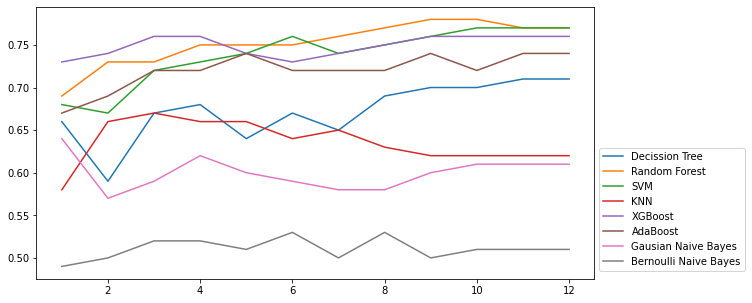

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(resultados["Decission Tree"], label="Decission Tree")
plt.plot(resultados["Random Forest"], label="Random Forest")
plt.plot(resultados["SVM"], label="SVM")
plt.plot(resultados["KNN"], label="KNN")
plt.plot(resultados["XGBoost"], label="XGBoost")
plt.plot(resultados["AdaBoost"], label="AdaBoost")
plt.plot(resultados["Gaussian Naive Bayes"], label="Gausian Naive Bayes")
plt.plot(resultados["Bernoulli Naive Bayes"], label="Bernoulli Naive Bayes")
plt.legend(bbox_to_anchor = (1, 0.5))
plt.show()